<a href="https://colab.research.google.com/github/BIJESHPATEL369/Semantic-Image-Segmentation-/blob/main/Semantic_Segmentaion_Pascal_Voc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Please run the notebook on High GPU to avoid session crash**

**Our Notebook is only supported for Google pro users if you want to run the training sections**

**Testing section is support for regular GPU Users**

# Installation

In [1]:
!pip install gdown

In [2]:
import gdown

url_train = 'https://drive.google.com/u/5/uc?id=1TNQYp4OEqCzTLQ2A_fFEbttpGwTOxDWL&export=download'
url_test = 'https://drive.google.com/u/5/uc?id=1JOxxgQ7tsNg3sR4Ry_HcfdMc8_4OVFsi&export=download'
url_val = 'https://drive.google.com/u/5/uc?id=1sRbpX2lItAw1UuNF3dZBe5sD3y80ooI4&export=download'

url_UNet_Model = 'https://drive.google.com/u/5/uc?id=1Vv450P0rajU2efKIT_61ryuEF_aMeu0v&export=download'
url_fcn = 'https://drive.google.com/u/5/uc?id=1MbxyTMgL8bgEGNU3KTackASVCDC1jOsy&export=download'

output = 'train_dataset_tv.pt'
gdown.download(url_train, output, quiet=False)

output1 = 'test_dataset.pt'
gdown.download(url_test, output1, quiet=False)

output2 = 'val_dataset_tv.pt'
gdown.download(url_val, output2, quiet=False)

output3 = 'unet_model.pt'
gdown.download(url_UNet_Model, output3, quiet=False)

output4 = 'fcn_model.pt'
gdown.download(url_fcn, output4, quiet=False)

Downloading...
From: https://drive.google.com/u/5/uc?id=1TNQYp4OEqCzTLQ2A_fFEbttpGwTOxDWL&export=download
To: /content/train_dataset_tv.pt
100%|██████████| 6.15G/6.15G [00:31<00:00, 197MB/s]
Downloading...
From: https://drive.google.com/u/5/uc?id=1JOxxgQ7tsNg3sR4Ry_HcfdMc8_4OVFsi&export=download
To: /content/test_dataset.pt
100%|██████████| 595M/595M [00:04<00:00, 134MB/s]
Downloading...
From: https://drive.google.com/u/5/uc?id=1sRbpX2lItAw1UuNF3dZBe5sD3y80ooI4&export=download
To: /content/val_dataset_tv.pt
100%|██████████| 6.15G/6.15G [00:38<00:00, 162MB/s]
Downloading...
From: https://drive.google.com/u/5/uc?id=1Vv450P0rajU2efKIT_61ryuEF_aMeu0v&export=download
To: /content/unet_model.pt
100%|██████████| 138M/138M [00:01<00:00, 98.7MB/s]
Downloading...
From: https://drive.google.com/u/5/uc?id=1MbxyTMgL8bgEGNU3KTackASVCDC1jOsy&export=download
To: /content/fcn_model.pt
100%|██████████| 150M/150M [00:01<00:00, 78.9MB/s]


'fcn_model.pt'

In [ ]:
!pip install torch torchvision

!pip install torchmetrics

     |████████████████████████████████| 408 kB 17.8 MB/s 


# Import Library

In [ ]:
import numpy as np
import pandas as pd

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch

from torchvision.datasets import VOCDetection
from torchvision.transforms import ToTensor
import os

from torchmetrics import JaccardIndex
from torchmetrics.functional import jaccard_index
from tqdm.notebook import tqdm

import torch.optim as optim

from torchmetrics import JaccardIndex
from torchmetrics.functional import jaccard_index

from torchvision.utils import save_image, make_grid
from mpl_toolkits.axes_grid1 import ImageGrid

import matplotlib.pyplot as plt

torch.manual_seed(1)

# Dataset

In [ ]:
def read_voc_images(voc_dir, is_train):
    """Read all VOC feature and label images."""
    
    if (is_train == "train"):
      image_txt = 'train.txt'
    elif (is_train == "val"):
      image_txt = 'val.txt'
    else:
      image_txt = 'test.txt'

    if(is_train == "train"):
      txt_fname_train = os.path.join(voc_dir, 'ImageSets', 'Segmentation', 'train.txt')
      txt_fname_val = os.path.join(voc_dir, 'ImageSets', 'Segmentation', 'val.txt')
    else:
      txt_fname = os.path.join(voc_dir, 'ImageSets', 'Segmentation', image_txt)

    mode = torchvision.io.image.ImageReadMode.RGB
    if(is_train == "train"):
      with open(txt_fname_train, 'r') as f:
          images_train = f.read().split()
      with open(txt_fname_val, 'r') as g:
          images_val = g.read().split()
    else:
      with open(txt_fname, 'r') as f:
          images_test = f.read().split()

    features, labels = [], []
    if(is_train == "train"):
      print(image_txt,"  : " ,len(images_train))
      for i, fname in enumerate(images_train):
          features.append(torchvision.io.read_image(os.path.join(
              voc_dir, 'JPEGImages', f'{fname}.jpg')))
          labels.append(torchvision.io.read_image(os.path.join(
              voc_dir, 'SegmentationClass' ,f'{fname}.png'), mode))
      print(image_txt,"  : " ,len(images_val))
      for i, fname in enumerate(images_val):
          features.append(torchvision.io.read_image(os.path.join(
              voc_dir, 'JPEGImages', f'{fname}.jpg')))
          labels.append(torchvision.io.read_image(os.path.join(
              voc_dir, 'SegmentationClass' ,f'{fname}.png'), mode))
    else:
      print(image_txt,"  : " ,len(images_test))
      for i, fname in enumerate(images_test):
          features.append(torchvision.io.read_image(os.path.join(
              voc_dir, 'JPEGImages', f'{fname}.jpg')))
          labels.append(torchvision.io.read_image(os.path.join(
              voc_dir, 'SegmentationClass' ,f'{fname}.png'), mode))
          
    return features, labels

VOC_COLORMAP = [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
                [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
                [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
                [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
                [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
                [0, 64, 128]]

VOC_CLASSES = ['background', 'aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
               'diningtable', 'dog', 'horse', 'motorbike', 'person',
               'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor']

def voc_colormap2label():
    """Build the mapping from RGB to class indices for VOC labels."""
    colormap2label = torch.zeros(256 ** 3, dtype=torch.long)
    for i, colormap in enumerate(VOC_COLORMAP):
        colormap2label[
            (colormap[0] * 256 + colormap[1]) * 256 + colormap[2]] = i
    return colormap2label

def voc_label_indices(colormap, colormap2label):
    """Map any RGB values in VOC labels to their class indices."""
    colormap = colormap.permute(1, 2, 0).numpy().astype('int32')
    idx = ((colormap[:, :, 0] * 256 + colormap[:, :, 1]) * 256
           + colormap[:, :, 2])
    return colormap2label[idx]

def voc_rand_crop(feature, label, height, width):
    """Randomly crop both feature and label images."""
    rect = torchvision.transforms.RandomCrop.get_params(
        feature, (height, width))
    feature = torchvision.transforms.functional.crop(feature, *rect)
    label = torchvision.transforms.functional.crop(label, *rect)
    return feature, label

class VOCSegDataset(torch.utils.data.Dataset):
    """A customized dataset to load the VOC dataset."""

    def __init__(self, is_train, crop_size, voc_dir):
        self.transform = torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        self.crop_size = crop_size
        features, labels = read_voc_images(voc_dir, is_train=is_train)
        self.features = [self.normalize_image(feature)
                         for feature in self.filter(features)]
        self.labels = self.filter(labels)
        self.colormap2label = voc_colormap2label()
        print('read ' + str(len(self.features)) + ' examples')

    def normalize_image(self, img):
        return self.transform(img.float() / 255)

    def filter(self, imgs):
        return [img for img in imgs if (
            img.shape[1] >= self.crop_size[0] and
            img.shape[2] >= self.crop_size[1])]

    def __getitem__(self, idx):
        feature, label = voc_rand_crop(self.features[idx], self.labels[idx],
                                       *self.crop_size)
        return (feature, voc_label_indices(label, self.colormap2label))

    def __len__(self):
        return len(self.features)

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


If you have very high GPU please uncomment the train dataset and validation dataset loader(session time out most likely if you use very low GPU).

For testing purpose you can only load test dataset

In [ ]:
# train_dataset = torch.load('train_dataset_tv.pt')

In [ ]:
# val_dataset = torch.load('val_dataset_tv.pt')

In [ ]:
test_dataset = torch.load('test_dataset.pt')

**Notes**

uncomment if you intend to load train and validation set (it requires high GPU). The code will take 1 hours to run.

In [ ]:
batch_size = 12

# uncomment if you intend to load train and validation set (it requires high GPU)
# train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True,
#                                     drop_last=True)

# val_dataloader  = torch.utils.data.DataLoader(val_dataset, batch_size, shuffle=True,
#                                     drop_last=True)

test_dataloader  = torch.utils.data.DataLoader(test_dataset, batch_size,
                                    drop_last=True)

In [ ]:
# print(len(train_dataloader))
# print(len(val_dataloader))
print(len(test_dataloader))

14


# U-Net Baseline Model

In [ ]:
class UNet(nn.Module):
    
    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.num_classes = num_classes
        self.contracting_11 = self.conv_block(in_channels=3, out_channels=64)
        self.contracting_12 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_21 = self.conv_block(in_channels=64, out_channels=128)
        self.contracting_22 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_31 = self.conv_block(in_channels=128, out_channels=256)
        self.contracting_32 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_41 = self.conv_block(in_channels=256, out_channels=512)
        self.contracting_42 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.middle = self.conv_block(in_channels=512, out_channels=1024)
        self.expansive_11 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_12 = self.conv_block(in_channels=1024, out_channels=512)
        self.expansive_21 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_22 = self.conv_block(in_channels=512, out_channels=256)
        
        self.expansive_31 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_32 = self.conv_block(in_channels=256, out_channels=128)
        self.expansive_41 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_42 = self.conv_block(in_channels=128, out_channels=64)
        self.output = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=3, stride=1, padding=1)
        
    def conv_block(self, in_channels, out_channels):
        block = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels),
                                    nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels))
        return block
    
    def forward(self, X):
        contracting_11_out = self.contracting_11(X) # [-1, 64, 256, 256]
        contracting_12_out = self.contracting_12(contracting_11_out) # [-1, 64, 128, 128]
        contracting_21_out = self.contracting_21(contracting_12_out) # [-1, 128, 128, 128]
        contracting_22_out = self.contracting_22(contracting_21_out) # [-1, 128, 64, 64]
        contracting_31_out = self.contracting_31(contracting_22_out) # [-1, 256, 64, 64]
        contracting_32_out = self.contracting_32(contracting_31_out) # [-1, 256, 32, 32]
        contracting_41_out = self.contracting_41(contracting_32_out) # [-1, 512, 32, 32]
        contracting_42_out = self.contracting_42(contracting_41_out) # [-1, 512, 16, 16]
        middle_out = self.middle(contracting_42_out) # [-1, 1024, 16, 16]
        expansive_11_out = self.expansive_11(middle_out) # [-1, 512, 32, 32]
        expansive_12_out = self.expansive_12(torch.cat((expansive_11_out, contracting_41_out), dim=1)) # [-1, 1024, 32, 32] -> [-1, 512, 32, 32]
        expansive_21_out = self.expansive_21(expansive_12_out) # [-1, 256, 64, 64]
        expansive_22_out = self.expansive_22(torch.cat((expansive_21_out, contracting_31_out), dim=1)) # [-1, 512, 64, 64] -> [-1, 256, 64, 64]
        expansive_31_out = self.expansive_31(expansive_22_out) # [-1, 128, 128, 128]
        expansive_32_out = self.expansive_32(torch.cat((expansive_31_out, contracting_21_out), dim=1)) # [-1, 256, 128, 128] -> [-1, 128, 128, 128]
        expansive_41_out = self.expansive_41(expansive_32_out) # [-1, 64, 256, 256]
        expansive_42_out = self.expansive_42(torch.cat((expansive_41_out, contracting_11_out), dim=1)) # [-1, 128, 256, 256] -> [-1, 64, 256, 256]
        output_out = self.output(expansive_42_out) # [-1, num_classes, 256, 256]
        return output_out

In [ ]:
num_classes = 21
model_unet = UNet(num_classes=num_classes)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [ ]:
model_unet.to(device)

UNet(
  (contracting_11): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (contracting_12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (contracting_21): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (contracting_22): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (contr

# FCN Model

In [ ]:
import math

class Bottleneck(nn.Module):
    """ResNet Bottleneck
    """
    # pylint: disable=unused-argument
    expansion = 4
    def __init__(self, inplanes, planes, stride=1, dilation=1,
                 downsample=None, previous_dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = norm_layer(planes)
        self.conv2 = nn.Conv2d(
            planes, planes, kernel_size=3, stride=stride,
            padding=dilation, dilation=dilation, bias=False)
        self.bn2 = norm_layer(planes)
        self.conv3 = nn.Conv2d(
            planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = norm_layer(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.dilation = dilation
        self.stride = stride

    def _sum_each(self, x, y):
        assert(len(x) == len(y))
        z = []
        for i in range(len(x)):
            z.append(x[i]+y[i])
        return z

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class ResNet(nn.Module):
    """Dilated Pre-trained ResNet Model, which preduces the stride of 8 featuremaps at conv5.

    Parameters
    ----------
    block : Block
        Class for the residual block. Options are BasicBlockV1, BottleneckV1.
    layers : list of int
        Numbers of layers in each block
    classes : int, default 1000
        Number of classification classes.
    dilated : bool, default False
        Applying dilation strategy to pretrained ResNet yielding a stride-8 model,
        typically used in Semantic Segmentation.
    norm_layer : object
        Normalization layer used in backbone network (default: :class:`mxnet.gluon.nn.BatchNorm`;
        for Synchronized Cross-GPU BachNormalization).

    Reference:

        - He, Kaiming, et al. "Deep residual learning for image recognition." Proceedings of the IEEE conference on computer vision and pattern recognition. 2016.

        - Yu, Fisher, and Vladlen Koltun. "Multi-scale context aggregation by dilated convolutions."
    """
    # pylint: disable=unused-variable
    def __init__(self, block, layers, num_classes=1000, dilated=True,
                 deep_base=True, norm_layer=nn.BatchNorm2d, output_size=8):
        self.inplanes = 128 if deep_base else 64
        super(ResNet, self).__init__()
        if deep_base:
            self.conv1 = nn.Sequential(
                nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1, bias=False),
                norm_layer(64),
                nn.ReLU(inplace=True),
                nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False),
                norm_layer(64),
                nn.ReLU(inplace=True),
                nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, bias=False),
            )
        else:
            self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                                   bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0], norm_layer=norm_layer)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, norm_layer=norm_layer)

        dilation_rate = 2
        if dilated and output_size <= 8:
            self.layer3 = self._make_layer(block, 256, layers[2], stride=1,
                                           dilation=dilation_rate, norm_layer=norm_layer)
            dilation_rate *= 2
        else:
            self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                           norm_layer=norm_layer)

        if dilated and output_size <= 16:
            self.layer4 = self._make_layer(block, 512, layers[3], stride=1,
                                           dilation=dilation_rate, norm_layer=norm_layer)
        else:
            self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                           norm_layer=norm_layer)

        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, norm_layer):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1, dilation=1, norm_layer=None):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                norm_layer(planes * block.expansion),
            )

        layers = []
        if dilation == 1 or dilation == 2:
            layers.append(block(self.inplanes, planes, stride, dilation=1,
                                downsample=downsample, previous_dilation=dilation, norm_layer=norm_layer))
        elif dilation == 4:
            layers.append(block(self.inplanes, planes, stride, dilation=2,
                                downsample=downsample, previous_dilation=dilation, norm_layer=norm_layer))
        else:
            raise RuntimeError("=> unknown dilation size: {}".format(dilation))

        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, dilation=dilation, previous_dilation=dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

def resnet50(dilated, norm_layer):
    """Constructs a ResNet-50 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 4, 6, 3])
    return model



In [ ]:
up_kwargs = {'mode': 'bilinear', 'align_corners': True}

class BaseNet(nn.Module):
    def __init__(self, nclass):
        super(BaseNet, self).__init__()
        self.nclass = nclass
        self.se_loss = False
        self.mean = [.485, .456, .406]
        self.std = [.229, .224, .225]
        self.base_size = 520
        self.crop_size = 480

        # copying modules from pretrained models
        self.pretrained = resnet50(dilated=False, norm_layer=None)
        
        # bilinear upsample options
        self._up_kwargs = up_kwargs
        #self.backbone = backbone

    def base_forward(self, x):
        x = self.pretrained.conv1(x)
        x = self.pretrained.bn1(x)
        x = self.pretrained.relu(x)
        x = self.pretrained.maxpool(x)
        c1 = self.pretrained.layer1(x)
        c2 = self.pretrained.layer2(c1)
        c3 = self.pretrained.layer3(c2)
        c4 = self.pretrained.layer4(c3)

        return c1, c2, c3, c4

    '''def evaluate(self, x, target=None):
        pred = self.forward(x)
        if isinstance(pred, (tuple, list)):
            pred = pred[0]
        if target is None:
            return pred
        correct, labeled = batch_pix_accuracy(pred.data, target.data)
        inter, union = batch_intersection_union(pred.data, target.data, self.nclass)
        return correct, labeled, inter, union'''

In [ ]:
class FCNHead(nn.Module):
    def __init__(self, in_channels, out_channels, norm_layer):
        super(FCNHead, self).__init__()
        inter_channels = in_channels // 4
        self.conv5 = nn.Sequential(nn.Conv2d(in_channels, inter_channels, 3, padding=1, bias=False),
                                   norm_layer(inter_channels),
                                   nn.ReLU(),
                                   nn.Dropout2d(0.1, False),
                                   nn.Conv2d(inter_channels, out_channels, 1))

    def forward(self, x):
        return self.conv5(x)

In [ ]:
from torch.nn.functional import interpolate

class FCN(BaseNet):
  def __init__(self, nclass):
    super(FCN, self).__init__(nclass)
    self.head = FCNHead(2048, nclass, nn.BatchNorm2d)
    self.auxlayer = FCNHead(1024, nclass, nn.BatchNorm2d)

  def forward(self, x):
    imsize = x.size()[2:]
    _, _, c3, c4 = self.base_forward(x)

    x = self.head(c4)
    x = interpolate(x, imsize, **self._up_kwargs)
    return x

    #auxout = self.auxlayer(c3)
    #auxout = interpolate(auxout, imsize, **self._up_kwargs)
    #outputs.append(auxout)
    #return c4

In [ ]:
num_classes = 21
model_fcn = FCN(num_classes)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [ ]:
model_fcn.to(device)

FCN(
  (pretrained): ResNet(
    (conv1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

## Training Unet Model

In [ ]:
lr = 0.0005
epochs = 33
# lr = 0.01
# lr = 0.0001
# lr= 1.0e-3
# weight_decay = 1e-4
# grad_clip = 0.1
# lr = 0.001 or 1.0e-3

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_unet.parameters(), lr = lr, betas=(0.5,0.999))

**Notes**

If training and validation sets were uncommented and assuming you have high gpu please uncomment this below section and run the code. The code will take 5 hours to train

In [ ]:
# epoch_train_loss = []
# epoch_val_loss = []

# iou_scores_train = []
# transform = torchvision.transforms.Normalize(
#             mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# for epoch in tqdm(range(epochs)):

#   # Training
#   model_unet.train()
#   total_train_loss = 0
#   iou_score_epoch_train = 0
#   iou_scores_per_epoch_train = []
#   for X,Y in tqdm(train_dataloader, total=len(train_dataloader)):
#     X, Y = X.to(device), Y.to(device)

#     # zero the parameter gradients
#     optimizer.zero_grad()

#     # forward + backward + optimize
#     Y_pred = model_unet(X)
#     loss = criterion(Y_pred, Y)

#     loss.backward()
#     optimizer.step()

#     total_train_loss += loss.item()

#     ground_truth_img_train = Y[0].cpu().detach().numpy()
#     predicted_img_train = Y_pred[0].cpu().detach().numpy()

#     inter_sec_train = np.logical_and(ground_truth_img_train, predicted_img_train)
#     union_train = np.logical_or(ground_truth_img_train, predicted_img_train)
#     iou_score_train = np.sum(inter_sec_train) / np.sum(union_train)

#     # iou_train = jaccard_index(Y_pred, Y, num_classes=21)

#     iou_scores_per_epoch_train.append(iou_score_train)

#   train_loss = total_train_loss/len(train_dataloader)
#   epoch_train_loss.append(train_loss)
#   iou_score_epoch_train = sum(iou_scores_per_epoch_train) / len(iou_scores_per_epoch_train)

#   # Validation
#   model_unet.eval()
#   total_val_loss = 0
#   iou_score_epoch_val = 0
#   iou_scores_per_epoch_val = []
#   with torch.no_grad():
#     for X_v,Y_v in tqdm(val_dataloader, total=len(val_dataloader)):
#       X_v, Y_v = X_v.to(device), Y_v.to(device)

#       optimizer.zero_grad()

#       Y_pred_v = model_unet(X_v)

#       loss_v = criterion(Y_pred_v, Y_v)

#       total_val_loss += loss_v.item()

#       ground_truth_img_val = Y_v[0].cpu().detach().numpy()
#       predicted_img_val = Y_pred_v[0].cpu().detach().numpy()

#       inter_sec_val = np.logical_and(ground_truth_img_val, predicted_img_val)
#       union_val = np.logical_or(ground_truth_img_val, predicted_img_val)
#       iou_score_val = np.sum(inter_sec_val) / np.sum(union_val)
      
#       # iou_val = jaccard_index(Y_pred_v, Y_v, num_classes=21)

#       # iou_scores_per_epoch_val.append(iou_val.item())

#       iou_scores_per_epoch_val.append(iou_score_val)

#   val_loss = total_val_loss/len(val_dataloader)
#   epoch_val_loss.append(val_loss)
#   iou_score_epoch_val = sum(iou_scores_per_epoch_val) / len(iou_scores_per_epoch_val)

#   print(f'Epoch {epoch+1}: train_loss: {train_loss:.4f}, train_iou: {iou_score_epoch_train:.4f} | val_loss: {val_loss:.4f}, val_iou: {iou_score_epoch_val:.4f} ')
#   # print(f'Epoch {epoch+1}: train_loss: {train_loss:.4f} ')

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 1: train_loss: 2.3976, train_iou: 0.2688 | val_loss: 2.0357, val_iou: 0.3030 


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 2: train_loss: 1.3559, train_iou: 0.2760 | val_loss: 1.2846, val_iou: 0.2161 


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 3: train_loss: 1.2619, train_iou: 0.2648 | val_loss: 1.2493, val_iou: 0.3141 


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 4: train_loss: 1.2502, train_iou: 0.2677 | val_loss: 1.2019, val_iou: 0.3244 


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 5: train_loss: 1.2275, train_iou: 0.2951 | val_loss: 1.1964, val_iou: 0.2110 


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 6: train_loss: 1.2158, train_iou: 0.2514 | val_loss: 1.2050, val_iou: 0.2520 


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 7: train_loss: 1.2019, train_iou: 0.3099 | val_loss: 1.1825, val_iou: 0.2648 


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 8: train_loss: 1.1850, train_iou: 0.2775 | val_loss: 1.1240, val_iou: 0.2635 


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 9: train_loss: 1.1715, train_iou: 0.2753 | val_loss: 1.1150, val_iou: 0.2743 


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 10: train_loss: 1.1592, train_iou: 0.2683 | val_loss: 1.1175, val_iou: 0.3209 


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 11: train_loss: 1.1413, train_iou: 0.2529 | val_loss: 1.0960, val_iou: 0.3224 


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 12: train_loss: 1.1123, train_iou: 0.2742 | val_loss: 1.0794, val_iou: 0.2594 


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 13: train_loss: 1.0960, train_iou: 0.2815 | val_loss: 1.0590, val_iou: 0.2311 


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 14: train_loss: 1.0764, train_iou: 0.2698 | val_loss: 1.0436, val_iou: 0.2996 


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 15: train_loss: 1.0589, train_iou: 0.2569 | val_loss: 0.9959, val_iou: 0.2948 


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 16: train_loss: 1.0393, train_iou: 0.2700 | val_loss: 1.0318, val_iou: 0.3793 


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 17: train_loss: 1.0323, train_iou: 0.2820 | val_loss: 0.9937, val_iou: 0.2189 


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 18: train_loss: 1.0175, train_iou: 0.2946 | val_loss: 1.0142, val_iou: 0.2450 


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 19: train_loss: 1.0135, train_iou: 0.2625 | val_loss: 1.1064, val_iou: 0.2810 


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 20: train_loss: 0.9999, train_iou: 0.2937 | val_loss: 1.0074, val_iou: 0.2525 


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 21: train_loss: 0.9880, train_iou: 0.2606 | val_loss: 1.0103, val_iou: 0.2474 


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 22: train_loss: 0.9796, train_iou: 0.2829 | val_loss: 0.9317, val_iou: 0.1939 


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 23: train_loss: 0.9737, train_iou: 0.2504 | val_loss: 1.0548, val_iou: 0.2609 


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 24: train_loss: 0.9663, train_iou: 0.2761 | val_loss: 0.9174, val_iou: 0.3055 


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 25: train_loss: 0.9603, train_iou: 0.2862 | val_loss: 0.9284, val_iou: 0.2400 


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 26: train_loss: 0.9398, train_iou: 0.2755 | val_loss: 0.9319, val_iou: 0.2752 


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 27: train_loss: 0.9338, train_iou: 0.2769 | val_loss: 0.9351, val_iou: 0.3254 


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 28: train_loss: 0.9312, train_iou: 0.2681 | val_loss: 0.9724, val_iou: 0.2469 


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 29: train_loss: 0.9208, train_iou: 0.3055 | val_loss: 0.9295, val_iou: 0.2865 


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 30: train_loss: 0.9154, train_iou: 0.2592 | val_loss: 0.9033, val_iou: 0.3047 


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 31: train_loss: 0.9124, train_iou: 0.2719 | val_loss: 0.9143, val_iou: 0.2451 


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 32: train_loss: 0.8968, train_iou: 0.2726 | val_loss: 0.9257, val_iou: 0.3022 


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 33: train_loss: 0.8892, train_iou: 0.2769 | val_loss: 0.8867, val_iou: 0.3302 


If training and validation sets were uncommented and assuming you have high gpu please uncomment this below section and run the code.

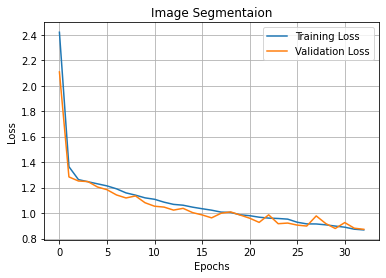

In [ ]:
# plt.plot(epoch_train_loss, label="Training Loss")
# plt.plot(epoch_val_loss, label="Validation Loss")
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.title('Image Segmentaion')
# plt.grid(True)
# plt.show()

In [ ]:
# path = "/content/drive/MyDrive/VOC Dataset/Unet_model_april_30_5:46pm_.pth"
# torch.save(model.state_dict(), path)

## Training FCN Model

In [ ]:
lr = 0.0005
epochs = 33
# lr = 0.01
# lr = 0.0001
# lr= 1.0e-3
# weight_decay = 1e-4
# grad_clip = 0.1
# lr = 0.001 or 1.0e-3

criterion = nn.CrossEntropyLoss()
optimizermodel_fcn = optim.Adam(model_fcn.parameters(), lr = lr, betas=(0.5,0.999))

**Notes**

If training and validation sets were uncommented and assuming you have high gpu please uncomment this below section and run the code. The code will take 5 hours to train

In [ ]:
# epoch_train_loss = []
# epoch_val_loss = []

# iou_scores_train = []
# transform = torchvision.transforms.Normalize(
#             mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# for epoch in tqdm(range(epochs)):

#   # Training
#   model_fcn.train()
#   total_train_loss = 0
#   iou_score_epoch_train = 0
#   iou_scores_per_epoch_train = []
#   for X,Y in tqdm(train_dataloader, total=len(train_dataloader)):
#     X, Y = X.to(device), Y.to(device)

#     # zero the parameter gradients
#     optimizermodel_fcn.zero_grad()

#     # forward + backward + optimize
#     Y_pred = model_fcn(X)
#     loss = criterion(Y_pred, Y)

#     loss.backward()
#     optimizermodel_fcn.step()

#     total_train_loss += loss.item()

#     ground_truth_img_train = Y[0].cpu().detach().numpy()
#     predicted_img_train = Y_pred[0].cpu().detach().numpy()

#     inter_sec_train = np.logical_and(ground_truth_img_train, predicted_img_train)
#     union_train = np.logical_or(ground_truth_img_train, predicted_img_train)
#     iou_score_train = np.sum(inter_sec_train) / np.sum(union_train)

#     # iou_train = jaccard_index(Y_pred, Y, num_classes=21)

#     iou_scores_per_epoch_train.append(iou_score_train)

#   train_loss = total_train_loss/len(train_dataloader)
#   epoch_train_loss.append(train_loss)
#   iou_score_epoch_train = sum(iou_scores_per_epoch_train) / len(iou_scores_per_epoch_train)

#   # Validation
#   model_fcn.eval()
#   total_val_loss = 0
#   iou_score_epoch_val = 0
#   iou_scores_per_epoch_val = []
#   with torch.no_grad():
#     for X_v,Y_v in tqdm(val_dataloader, total=len(val_dataloader)):
#       X_v, Y_v = X_v.to(device), Y_v.to(device)

#       optimizermodel_fcn.zero_grad()

#       Y_pred_v = model_fcn(X_v)

#       loss_v = criterion(Y_pred_v, Y_v)

#       total_val_loss += loss_v.item()

#       ground_truth_img_val = Y_v[0].cpu().detach().numpy()
#       predicted_img_val = Y_pred_v[0].cpu().detach().numpy()

#       inter_sec_val = np.logical_and(ground_truth_img_val, predicted_img_val)
#       union_val = np.logical_or(ground_truth_img_val, predicted_img_val)
#       iou_score_val = np.sum(inter_sec_val) / np.sum(union_val)
      
#       # iou_val = jaccard_index(Y_pred_v, Y_v, num_classes=21)

#       # iou_scores_per_epoch_val.append(iou_val.item())

#       iou_scores_per_epoch_val.append(iou_score_val)

#   val_loss = total_val_loss/len(val_dataloader)
#   epoch_val_loss.append(val_loss)
#   iou_score_epoch_val = sum(iou_scores_per_epoch_val) / len(iou_scores_per_epoch_val)

#   print(f'Epoch {epoch+1}: train_loss: {train_loss:.4f}, train_iou: {iou_score_epoch_train:.4f} | val_loss: {val_loss:.4f}, val_iou: {iou_score_epoch_val:.4f} ')
#   # print(f'Epoch {epoch+1}: train_loss: {train_loss:.4f} ')

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 1: train_loss: 1.4670, train_iou: 0.2797 | val_loss: 1.2247, val_iou: 0.2679 


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 2: train_loss: 1.1993, train_iou: 0.2568 | val_loss: 1.1332, val_iou: 0.3064 


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 3: train_loss: 1.1505, train_iou: 0.2530 | val_loss: 1.1155, val_iou: 0.2891 


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 4: train_loss: 1.1106, train_iou: 0.2513 | val_loss: 1.0839, val_iou: 0.2761 


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 5: train_loss: 1.0735, train_iou: 0.2627 | val_loss: 1.0746, val_iou: 0.2405 


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 6: train_loss: 1.0434, train_iou: 0.2484 | val_loss: 1.0373, val_iou: 0.3255 


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 7: train_loss: 1.0113, train_iou: 0.2473 | val_loss: 0.9562, val_iou: 0.2132 


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 8: train_loss: 0.9778, train_iou: 0.2609 | val_loss: 0.9583, val_iou: 0.2790 


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 9: train_loss: 0.9408, train_iou: 0.2602 | val_loss: 1.0052, val_iou: 0.3324 


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 10: train_loss: 0.9171, train_iou: 0.3019 | val_loss: 0.9047, val_iou: 0.2402 


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 11: train_loss: 0.8916, train_iou: 0.2626 | val_loss: 0.9254, val_iou: 0.2527 


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 12: train_loss: 0.8509, train_iou: 0.2407 | val_loss: 0.8675, val_iou: 0.2968 


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 13: train_loss: 0.8237, train_iou: 0.2895 | val_loss: 0.9747, val_iou: 0.3050 


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 14: train_loss: 0.7964, train_iou: 0.2887 | val_loss: 0.8516, val_iou: 0.2736 


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 15: train_loss: 0.7656, train_iou: 0.2875 | val_loss: 0.8086, val_iou: 0.2838 


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 16: train_loss: 0.7461, train_iou: 0.2818 | val_loss: 0.8977, val_iou: 0.2920 


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 17: train_loss: 0.7210, train_iou: 0.2651 | val_loss: 0.8656, val_iou: 0.3496 


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 18: train_loss: 0.6846, train_iou: 0.2700 | val_loss: 0.8282, val_iou: 0.2358 


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 19: train_loss: 0.6594, train_iou: 0.2569 | val_loss: 0.8374, val_iou: 0.2406 


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 20: train_loss: 0.6257, train_iou: 0.2705 | val_loss: 0.7604, val_iou: 0.2651 


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 21: train_loss: 0.6037, train_iou: 0.2908 | val_loss: 0.8545, val_iou: 0.2935 


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 22: train_loss: 0.5693, train_iou: 0.2793 | val_loss: 0.8425, val_iou: 0.2211 


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 23: train_loss: 0.5383, train_iou: 0.2893 | val_loss: 0.8542, val_iou: 0.2731 


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 24: train_loss: 0.5015, train_iou: 0.2561 | val_loss: 0.8142, val_iou: 0.3497 


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 25: train_loss: 0.4750, train_iou: 0.2725 | val_loss: 0.8711, val_iou: 0.2990 


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 26: train_loss: 0.4392, train_iou: 0.2736 | val_loss: 0.8350, val_iou: 0.3022 


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 27: train_loss: 0.4238, train_iou: 0.2600 | val_loss: 0.7907, val_iou: 0.2868 


If training and validation sets were uncommented and assuming you have high gpu please uncomment this below section and run the code.

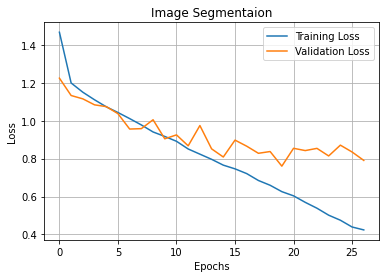

In [ ]:
# plt.plot(epoch_train_loss, label="Training Loss")
# plt.plot(epoch_val_loss, label="Validation Loss")
# plt.xlabel('Epochs')
# plt.ylabel('Loss')

# plt.legend()
# plt.title('Image Segmentaion')
# plt.grid(True)
# plt.show() 

In [ ]:
# path = "/content/drive/MyDrive/VOC Dataset/Unet_model_april_30_5:46pm_.pth"
# torch.save(model.state_dict(), path)

# Evaluation on test set

## U-Net Model testing

In [ ]:
path = "/content/unet_model.pt"
model_unet.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
lr = 0.0005
epochs = 33

criterion = nn.CrossEntropyLoss()
optimizermodel = optim.Adam(model_unet.parameters(), lr = lr, betas=(0.5,0.999))

In [ ]:
model_unet.eval()
total_test_loss = 0
iou_score_epoch_test = 0
iou_scores_per_epoch_test = []
with torch.no_grad():
  for X_test,Y_test in tqdm(test_dataloader, total=len(test_dataloader)):
    X_test, Y_test = X_test.to(device), Y_test.to(device)

    optimizermodel.zero_grad()

    Y_pred_test = model_unet(X_test)

    loss_test = criterion(Y_pred_test, Y_test)

    total_test_loss += loss_test.item()

    iou = jaccard_index(Y_pred_test, Y_test, num_classes=21)
    iou_scores_per_epoch_test.append(iou.item())

test_loss = total_test_loss/len(test_dataloader)
iou_score_epoch_test = sum(iou_scores_per_epoch_test) / len(iou_scores_per_epoch_test)

print(f'test_loss: {test_loss:.4f}, test_iou: {iou_score_epoch_test:.4f} ')

  0%|          | 0/14 [00:00<?, ?it/s]

test_loss: 0.2732, test_iou: 0.3860 


## FCNModel Testing

In [ ]:
path = "fcn_model.pt"
model_fcn.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
lr = 0.0005
epochs = 33

criterion = nn.CrossEntropyLoss()
optimizermodel_fcn = optim.Adam(model_fcn.parameters(), lr = lr, betas=(0.5,0.999))

In [ ]:
model_fcn.eval()
total_test_loss = 0
iou_score_epoch_test = 0
iou_scores_per_epoch_test = []
with torch.no_grad():
  for X_test,Y_test in tqdm(test_dataloader, total=len(test_dataloader)):
    X_test, Y_test = X_test.to(device), Y_test.to(device)

    optimizermodel_fcn.zero_grad()

    Y_pred_test = model_fcn(X_test)

    loss_test = criterion(Y_pred_test, Y_test)

    total_test_loss += loss_test.item()

    iou = jaccard_index(Y_pred_test, Y_test, num_classes=21)
    iou_scores_per_epoch_test.append(iou.item())

test_loss = total_test_loss/len(test_dataloader)
iou_score_epoch_test = sum(iou_scores_per_epoch_test) / len(iou_scores_per_epoch_test)

print(f'test_loss: {test_loss:.4f}, test_iou: {iou_score_epoch_test:.4f} ')

  0%|          | 0/14 [00:00<?, ?it/s]

test_loss: 0.2456, test_iou: 0.4238 


# Display Resuts on test sets

## U-net model demonstration

In [ ]:
trans = torchvision.transforms.Compose([transforms.ToTensor()])

transform = torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

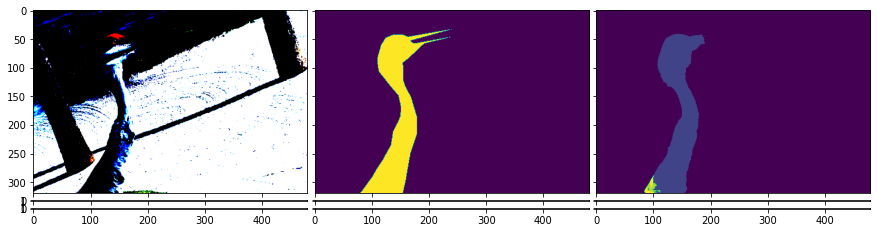

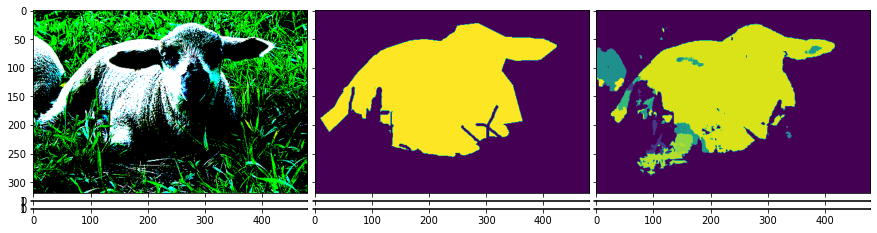

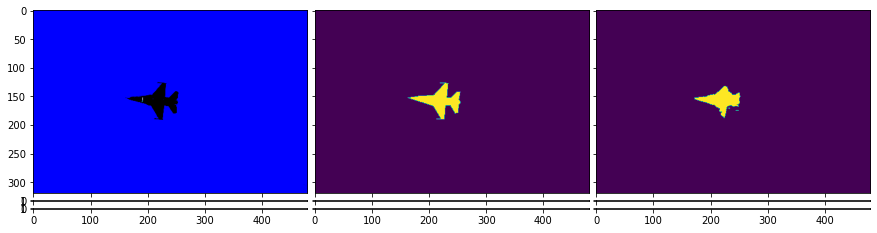

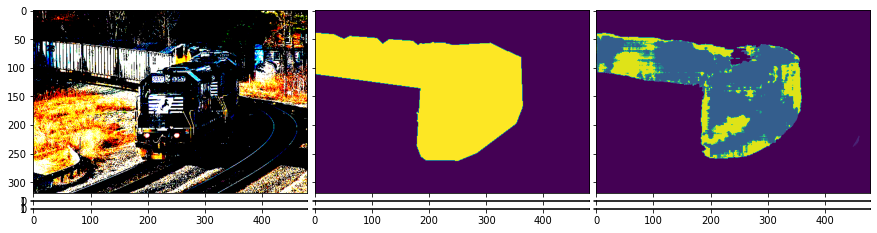

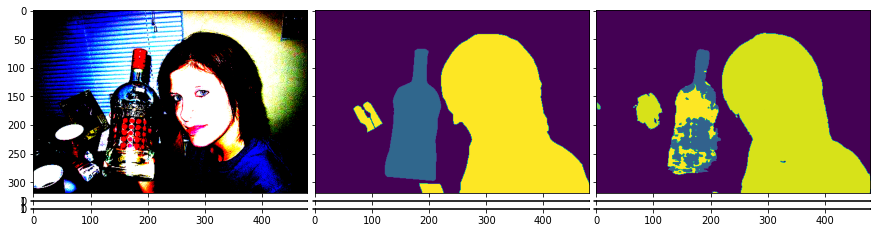

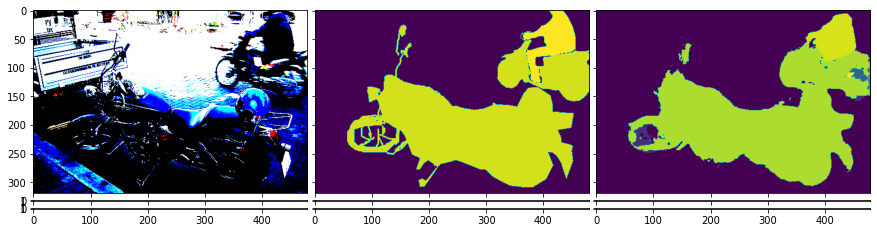

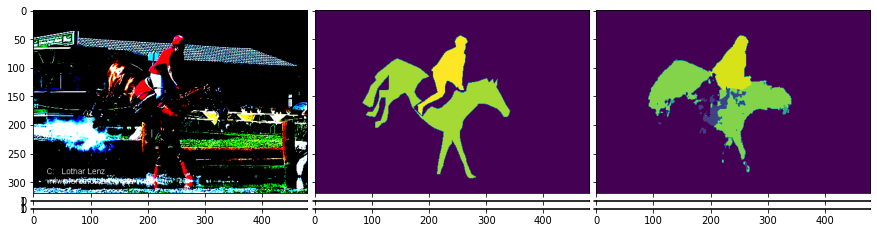

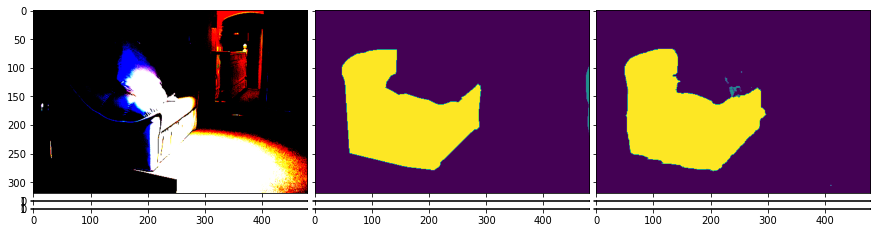

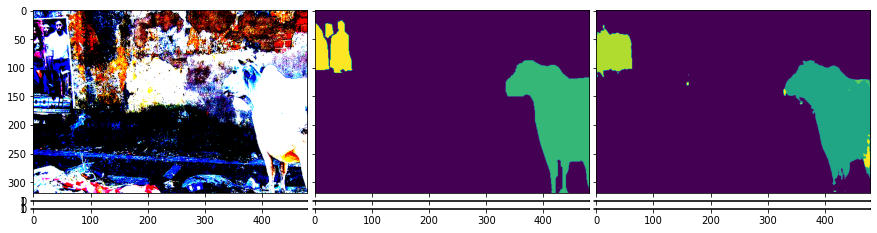

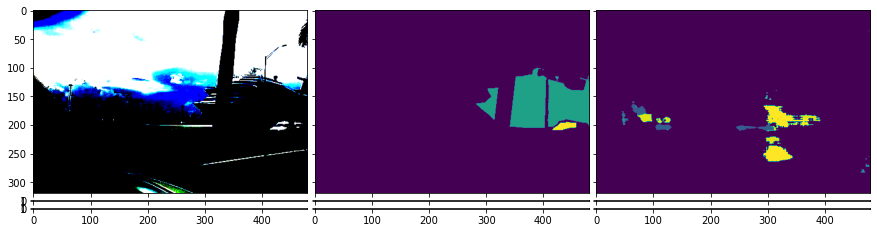

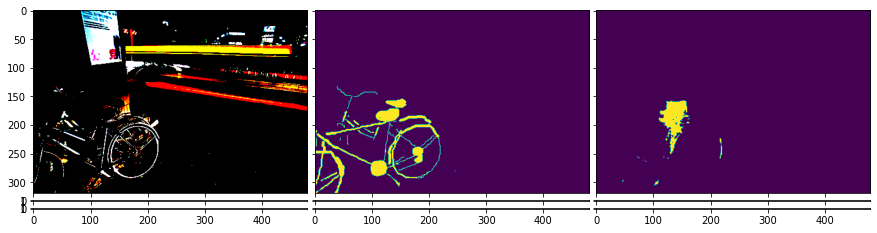

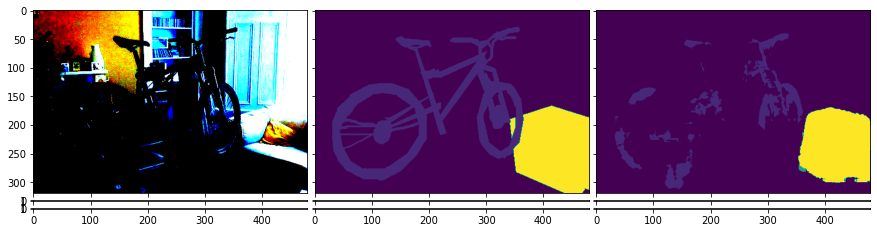

In [ ]:
X_p,Y_p = next(iter(test_dataloader))

X_p,Y_p = X_p.to(device), Y_p.to(device)
Y_pred_test = model_unet(X_p)
Y_pred_test = torch.argmax(Y_pred_test, dim=1)
for i in range(len(X_p)):
  original_image = transform(X_p[i]).permute(1, 2, 0).cpu().detach().numpy()
  ground_truth_image = Y_p[i].cpu().detach().numpy()  
  predicted_image = Y_pred_test[i].cpu().detach().numpy()

  fig = plt.figure(figsize=(15., 15.))
  grid = ImageGrid(fig, 111,  
                  nrows_ncols=(3, 3), 
                  axes_pad=0.1,  
                  )

  for ax, im in zip(grid, [original_image, ground_truth_image, predicted_image]):
      ax.imshow(im)
plt.show()

## FCN model demonstration

In [ ]:
trans = torchvision.transforms.Compose([transforms.ToTensor()])

transform = torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

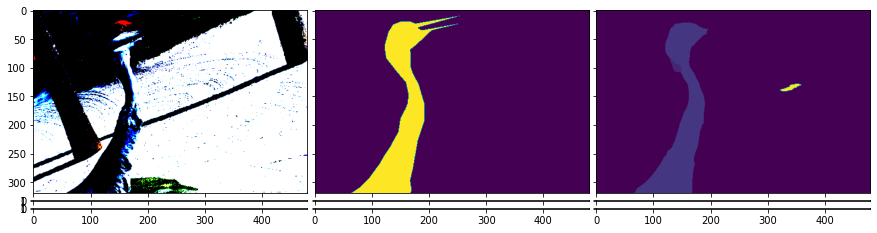

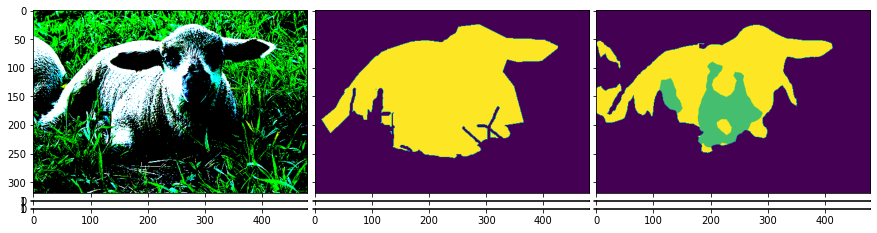

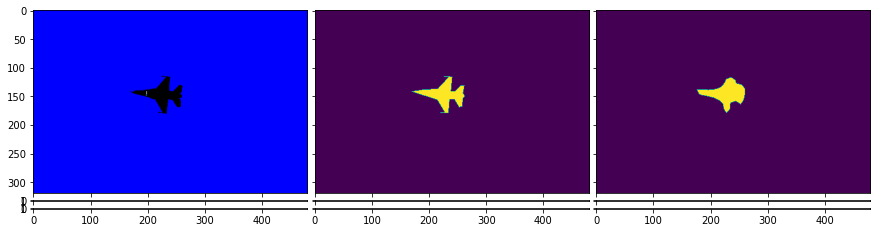

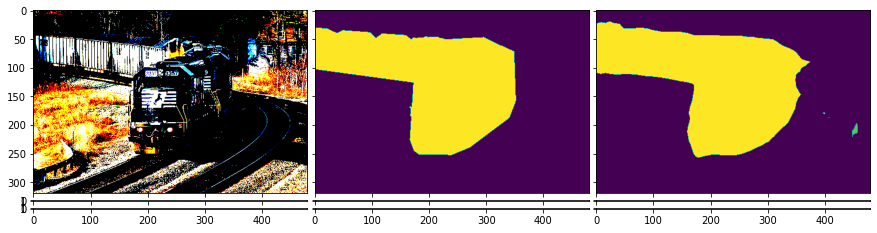

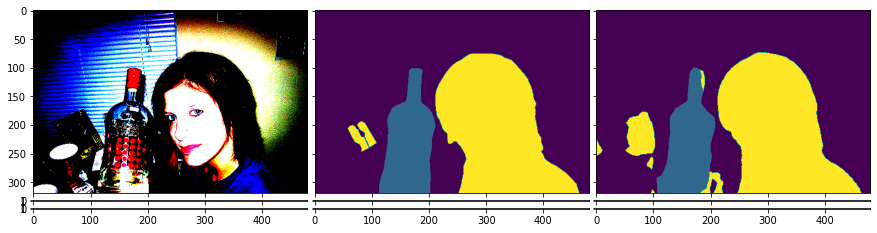

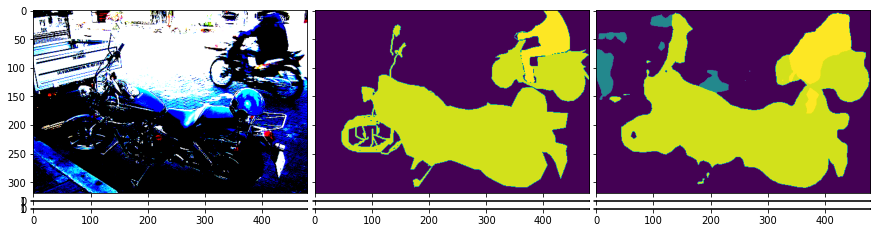

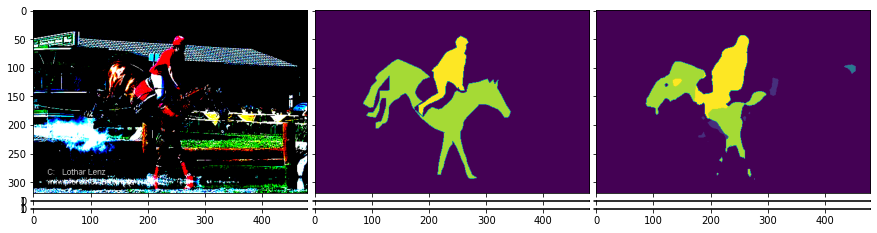

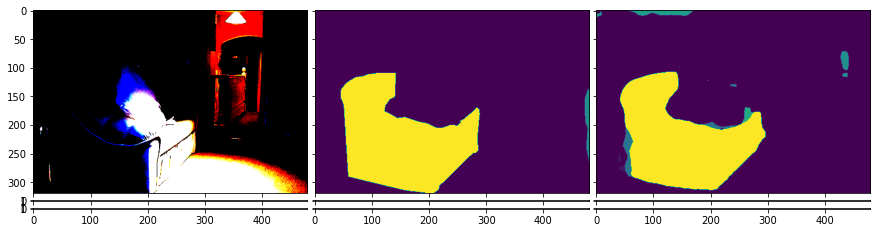

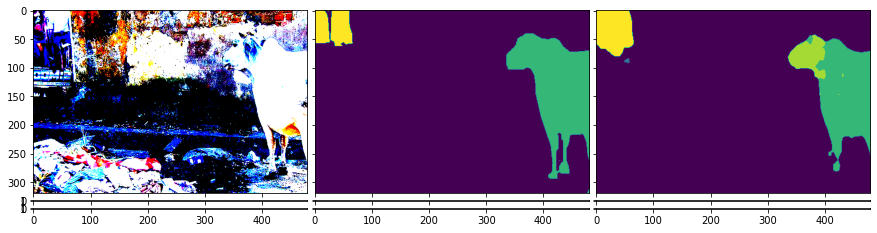

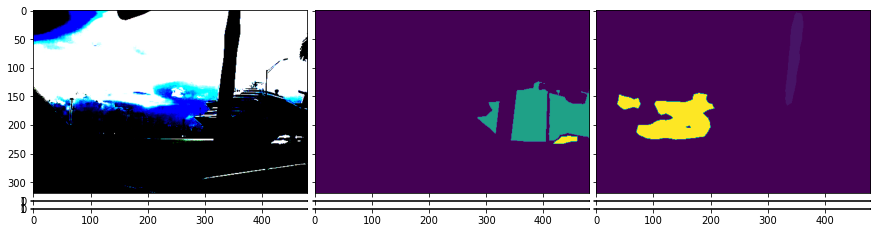

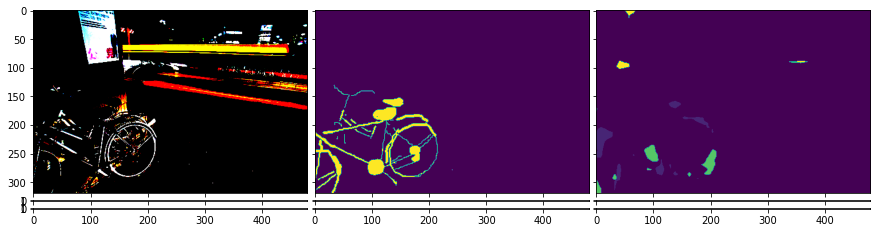

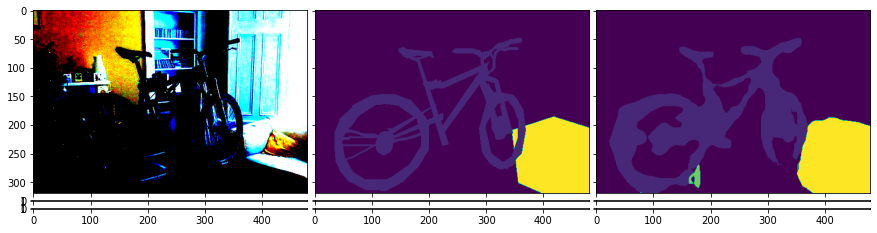

In [ ]:
X_p,Y_p = next(iter(test_dataloader))

X_p,Y_p = X_p.to(device), Y_p.to(device)
Y_pred_test = model_fcn(X_p)
Y_pred_test = torch.argmax(Y_pred_test, dim=1)
for i in range(len(X_p)):
  original_image = transform(X_p[i]).permute(1, 2, 0).cpu().detach().numpy()
  ground_truth_image = Y_p[i].cpu().detach().numpy()  
  predicted_image = Y_pred_test[i].cpu().detach().numpy()

  fig = plt.figure(figsize=(15., 15.))
  grid = ImageGrid(fig, 111,  
                  nrows_ncols=(3, 3), 
                  axes_pad=0.1,  
                  )

  for ax, im in zip(grid, [original_image, ground_truth_image, predicted_image]):
      ax.imshow(im)
plt.show()